# Task 1: Quantum Approximation Optimization Algorithms - Iñigo Lara

## Introduction:

In this notebbook I solve Screening Task 1 for the [QOSF](https://qosf.org/qc_mentorship/) Mentorship Program:

Given a certain ket $|\psi>$, optimize a variational quantum circuit $U(\theta)$ so that $|\phi> \equiv U(\theta)|0>\rightarrow |\psi>$. We work on a quantum circuit of 4 qubits.

I will use PennyLane QML package, as it provides a simple way to implement gradient descent to tune the hyperparameters $\theta$.

**Cost function**

It is proposed to use $||\phi>-|\psi>||$ as a measure of closeliness. This simplifies to:

$$||\phi>-|\psi>||^{2} = (<\phi|-<\psi|)(|\phi>-\psi>) = 2 - <\phi|\psi> - <\psi|\phi> = 2[1-Re(<\psi|\phi>)]$$

I have found it tricky to implement directly that loss function in PennyLane. Instead, I have used a Fidelity approach, that I discuss later.

## Solution implementation:

In [6]:
import pennylane as qml
from pennylane import numpy as np

### Operators:

The circuit is a sandwich that takes the form:

$$|\text{Initial state}> ----[Even]-[Odd]----[Even]-[Odd]----[Even]-[Odd]----[Even]-[Odd]----...$$

The number of times we repeat [Even-Odd] is the 'number of layers'.

In [7]:
n_wires = 4  # number of qubits

In [8]:
def Even(thetaEven):
    """ Applies a set of RZ(theta) to all the qubits """
    for wire in range(n_wires):
        qml.RX(thetaEven[wire], wires=wire)


def Odd(thetaOdd):
    """ Applies a set of RZ(theta) followed by CZ entanglement between every pair of qubits """
    for wire in range(n_wires):
        qml.RZ(thetaOdd[wire], wires=wire)
        for i in range(n_wires):
            for j in range(i+1, n_wires):
                qml.CZ(wires=[i, j])

### Circuit:

In [9]:
dev = qml.device("default.qubit", wires=n_wires)

Instead of computing $||𝜙>−|𝜓>||$ for the cost function, I will use the Fidelity between two states ($F=|<\psi|\phi>|$). Then, we can define the cost as $1-F$, that reaches it's minimum when $F=1$ ( $0\leq F\leq1$ ). This happens when $|\phi> = |\psi>$, up to a global phase.

I made this choice given the difficulties to compute $||𝜙>−𝜓>||$ in the PennyLane API (In Qiskit it was easier, but on the other hand the optimization code was much clumsier). This is because PennyLane is best used to get expectation values. With this thought in mind, I decided to use the Fidelity, because it can be expressed as the expectation value of the following density matrix: $|\psi><\psi|$, where $|\psi>$ is the state we want:

$$F = |<\psi|\phi>| = \sqrt{<\psi|\phi>|<\phi|\psi>|}$$

Moreover, as $|<\psi|\phi>| \geq Re(<\psi|\phi>)$, the Fidelity metric will be an overestimation of the proposed metric in the worst case.ç

If the optimization converges, we will have a state $|\psi>$ such that $|<\psi|\phi>|=1$.
Note that it may happen $|\phi> = e^{i\delta}\psi>$. However, a global phase is never a major problem...

In [10]:
def density_matrix(state):
    """  Calculates the density matrix representation of a state (a state is a complex vector
         in the canonical basis representation). The density matrix is a Hermitian operator.
    """
    return np.outer(np.conj(state), state)

In [11]:
@qml.qnode(dev)
def circuit(thetaEven_s, thetaOdd_s, n_layers=1):
    """ Combines the different layers and outputs F^2 (Fidelity squared) """
    for i in range(n_layers):
        Even(thetaEven_s[i])
        Odd(thetaEven_s[i])
    # during the optimization phase we are evaluating the following expected value:
    return qml.expval(qml.Hermitian(density_matrix(desired_state), wires=[0, 1, 2, 3]))

### Optimization:

In [41]:
def QAOA(n_layers=1, verbose=False):
    """ Quantum Approximation Optimization Algorithm:
        Uses a Nesterov Momentum optimizer to variate the hyperparameters theta (one per gate Rx, Rz and layer)
        to minimize the cost 1 - F.
    """
    init_params = 2*np.pi*np.random.rand(2, n_layers, n_wires)  # Possible improvement: limit params. to [0, 2pi) (due to periodicity)

    def cost(params):
        thetaEven_s = params[0]
        thetaOdd_s = params[1]
        return (1-np.sqrt(circuit(thetaEven_s, thetaOdd_s, n_layers=n_layers)))

    # itialize optimizer: Nesterov with momentum chosen after trying various
    opt = qml.NesterovMomentumOptimizer(stepsize=0.02, momentum=0.9)

    losses = []
    steps = 250
    
    # optimize parameters in cost
    params = init_params
    for i in range(steps):
        params = opt.step(cost, params)
        loss = cost(params)
        losses.append(loss)
        if verbose==True:
            if (i + 1) % 5 == 0:
                print("Objective after step {:5d}: {: .7f}".format(i + 1, loss))
    print("Layer architecture {0} finished".format(n_layers))
    return losses

### Execution:

First, we need a vector that we want to approximate: $|\phi>$.

I generate it as a random normalized complex vector in the canonical basis

In [42]:
def norm(x):
    """ Norm of a quantum state: ||x|| = (<x|x>)^1/2 """
    return np.sqrt(np.sum(np.absolute(x)**2))

In [43]:
np.random.seed(42)

desired_state = np.random.random(2**n_wires) + np.random.random(2**n_wires) * 1j

desired_state = desired_state/norm(desired_state)  # normalize

Then, we define a set of circuit architectures and we get the evolution of the losses:

In [44]:
layer_list = [1, 3, 5, 7, 9]

### Results:

In [45]:
def getLosses(layer_list):
    """
    Returns a list of losses for the different layer setups in layerList.
    """
    
    losses_list = [QAOA(i) for i in layer_list]
    return losses_list

In [46]:
losses_list = getLosses(layer_list)

Layer architecture 1 finished
Layer architecture 3 finished
Layer architecture 5 finished
Layer architecture 7 finished
Layer architecture 9 finished


In [47]:
final_losses = [i[-1] for i in losses_list]
for i in range(len(layer_list)):
    print('Layer : {} | Loss : {}'.format(layer_list[i], final_losses[i]))

Layer : 1 | Loss : 0.1444954673323764
Layer : 3 | Loss : 0.11044465175589535
Layer : 5 | Loss : 0.10960262854328096
Layer : 7 | Loss : 0.10960262819114885
Layer : 9 | Loss : 0.10960262819145461


### Visualization

In [48]:
import matplotlib.pyplot as plt

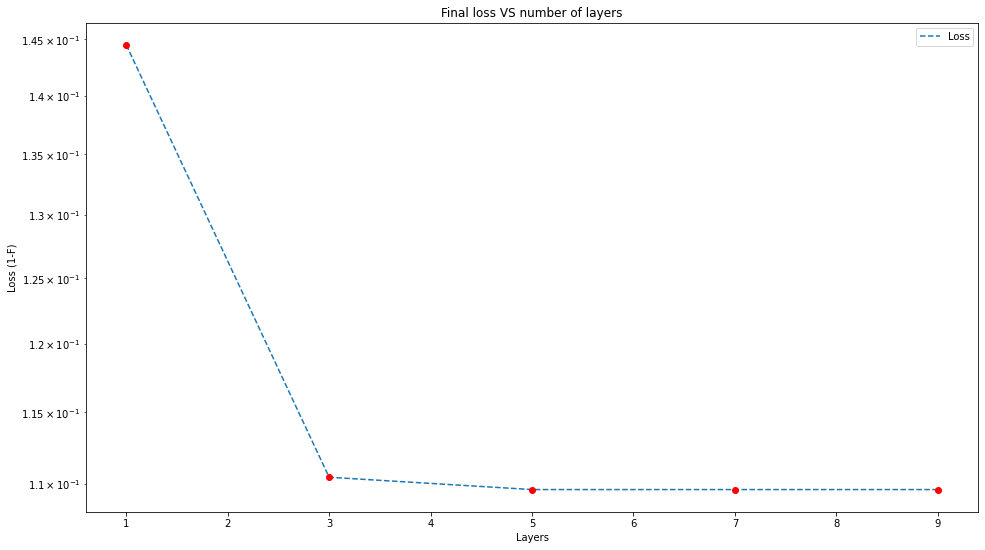

In [55]:
x = [i for i in layer_list]
plt.figure(figsize=[16, 9])
plt.yscale('log')
plt.plot(x, final_losses, '--')
plt.plot(x, final_losses, 'ro')
plt.xlabel('Layers')
plt.ylabel('Loss (1-F)')
plt.legend(['Loss'])
plt.title('Final loss VS number of layers')
plt.show()

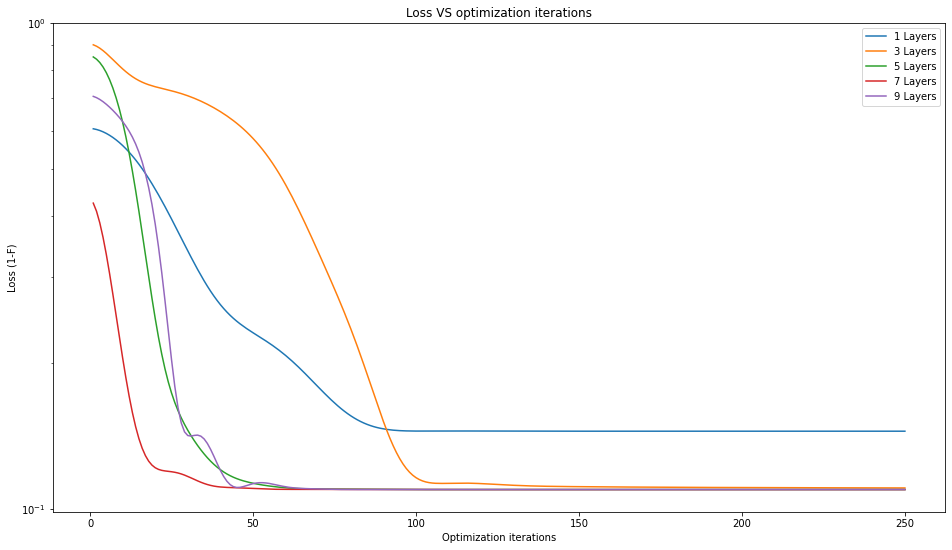

In [53]:
plt.figure(figsize=[16, 9])
plt.yscale('log')
x2 = [i + 1 for i in range(len(losses_list[0]))]
for i in losses_list:
    plt.plot(x2, i)
legendList = ['{} Layers'.format(i) for i in layer_list]
plt.xlabel('Optimization iterations')
plt.ylabel('Loss (1-F)')
plt.legend(legendList)
plt.title('Loss VS optimization iterations')
plt.show()

### Conclusion:

Naively, one would expect that the more the number of layers, the better the performance. This is the case. However, this improvement is not that explicit from the graph above. Even though the more the layers the more rapidly the loss gets minimized, the changes are small and they even invert for $l=7$ and $l=9$.
Mofreover, one can see that Fidelity raises up to $0.9$, but does not go any further. Not even for the bigger circuits. This is a strange behaviour for which I have some tentative explanations, that I develop below:

It may happen that the Fidelity cost function being used gets stuck in local minima easily, as it has a phase redundancy. This could be avoided, for example, taking into account the symmetries of the system and limiting the values of $\theta$ to $[0, 2\pi]$.

It can also happen neither the bigger nor the smaller architectures are capable to cover properly Hilbert's space. This could be the case, as $10*8=80$ parameters (degrees of freedom) that we have in the biggest case is small compared to the $16*16\sim 256$ degrees of freedom of unitary matrix ($n^{2}-1$).

Personally, I tend to think that the behaviour of the plot is related to the fact that I am using the Fidelity cost function. Though the final result is a fidelity of $90$%, which is not as good as expected, but not bad either.


**Anyway...**

It has been an interesting first approach to QML, as it was an interesting task with many subtleties to explore. I would have liked to build noise models to test the circuits with, in order to model deocherence. Moreover, it would have been interesting to run the experiments in an actual quantum computer.

Hopefully, we will be able to do that in not that much time!